# YOLOv8n Object Detection Model Training - Adjunct Vessel Length Regressor

## 1. Setup

In [1]:
import numpy as np
import cv2
import glob as glob
import yaml
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from ultralytics import YOLO

import tensorflow as tf
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from utilities import *
from plot_loss_curves import plot_total_loss
from du_utilities import *

from match_png_vessel_lengths import build_image_vessel_length_table
from extract_features import extract_features
from rf_vlen_regressor import  VesselLengthRegressor

from run_inference_and_export import run_inference_and_save_results
from crops_analyser import analyse_crops

ModuleNotFoundError: No module named 'utilities'

## 2. Vessel detection model evaluation

### 3.2 MLP regressor

In [8]:
from mlp_vessel_regressor import *

# Reset the name counters
tf.keras.backend.clear_session()

In [9]:
# Create model architecture
model = create_mlp_model(input_dim=4, hidden_layers=[32, 16, 8])

I0000 00:00:1756737539.951432 2730954 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5566 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Setup target (vessel length) scaling
y_scaler, y_train_scaled = setup_target_scaler(y_train)
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

In [12]:
# Create custom loss function - Absolute Relative Error (scaled)
loss_function = create_custom_loss(y_scaler)

In [13]:
# Compile with custom ARE loss and SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00025, momentum=0.9, nesterov=True)
model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae'])

In [14]:
# Setup VLA and model checkpoint callbacks
checkpoint_path = '../models/mlp/best_model.keras'
callbacks = create_callbacks(checkpoint_path, X_val, y_val, y_scaler, vla_freq=5)

In [15]:
# Train model
tf.random.set_seed(42)
    
history = model.fit(
    X_train, y_train_scaled,
    batch_size=32,
    epochs=120,
    shuffle=True,
    validation_data=(X_val, y_val_scaled),
    callbacks=callbacks,
    verbose=0
)

I0000 00:00:1756737575.495403 2731080 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1 - Validation VLA: 0.602

Epoch 6 - Validation VLA: 0.673

Epoch 11 - Validation VLA: 0.682

Epoch 16 - Validation VLA: 0.684

Epoch 21 - Validation VLA: 0.685

Epoch 26 - Validation VLA: 0.688

Epoch 31 - Validation VLA: 0.686

Epoch 36 - Validation VLA: 0.686

Epoch 41 - Validation VLA: 0.685

Epoch 46 - Validation VLA: 0.685

Epoch 51 - Validation VLA: 0.686

Epoch 56 - Validation VLA: 0.687

Epoch 61 - Validation VLA: 0.687

Epoch 66 - Validation VLA: 0.688

Epoch 71 - Validation VLA: 0.689

Epoch 76 - Validation VLA: 0.692

Epoch 81 - Validation VLA: 0.692

Epoch 86 - Validation VLA: 0.693

Epoch 91 - Validation VLA: 0.695

Epoch 96 - Validation VLA: 0.694

Epoch 101 - Validation VLA: 0.696

Epoch 106 - Validation VLA: 0.697

Epoch 111 - Validation VLA: 0.695

Epoch 116 - Validation VLA: 0.695


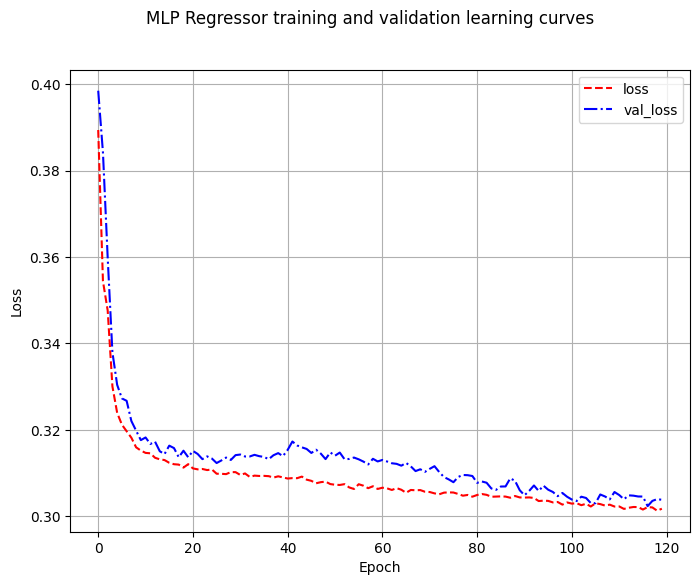

In [16]:
# Plot learning curves
fig = plot_learning_curves(history, title="MLP Regressor training and validation learning curves", figsize=(8, 6))

In [17]:
# Load best model (after training)
best_model = load_mlp_model(checkpoint_path, y_scaler)

Complete model loaded from ../models/mlp/best_model.keras


In [18]:
# Save figure if required
save_fig("../models/mlp/mlp_loss_(4_32-16-8_lr25e-5)", fig=fig)

Figure saved as: ../models/mlp/mlp_loss_(4_32-16-8_lr25e-5).pdf


In [19]:
y_train_pred = make_predictions(best_model, X_train, y_scaler)
y_val_pred = make_predictions(best_model, X_val, y_scaler)
y_test_pred = make_predictions(best_model, X_test, y_scaler)

In [20]:
# Calculate and display metrics for each split
train_mlp_metrics = calculate_metrics_by_class(y_train, y_train_pred, X_train[:, -1], "Training")
val_mlp_metrics = calculate_metrics_by_class(y_val, y_val_pred, X_val[:, -1], "Validation")
test_mlp_metrics = calculate_metrics_by_class(y_test, y_test_pred, X_test[:, -1], "Test")


=== Training Metrics ===
Overall      MAE:  17.24, RMSE:  29.69, R²:  0.697, VLA:  0.694
is_vessel    MAE:  31.68, RMSE:  44.51, R²:  0.353, VLA:  0.666 (n=2863)
is_fishing   MAE:   8.39, RMSE:  14.44, R²:  0.129, VLA:  0.712 (n=4673)

=== Validation Metrics ===
Overall      MAE:  24.73, RMSE:  34.33, R²:  0.627, VLA:  0.698
is_vessel    MAE:  30.25, RMSE:  39.29, R²:  0.412, VLA:  0.699 (n=219)
is_fishing   MAE:   9.01, RMSE:  11.84, R²: -0.075, VLA:  0.693 (n=77)

=== Test Metrics ===
Overall      MAE:  29.54, RMSE:  41.75, R²:  0.486, VLA:  0.621
is_vessel    MAE:  32.83, RMSE:  44.58, R²:  0.350, VLA:  0.608 (n=168)
is_fishing   MAE:   7.45, RMSE:   9.78, R²:  0.185, VLA:  0.710 (n=25)


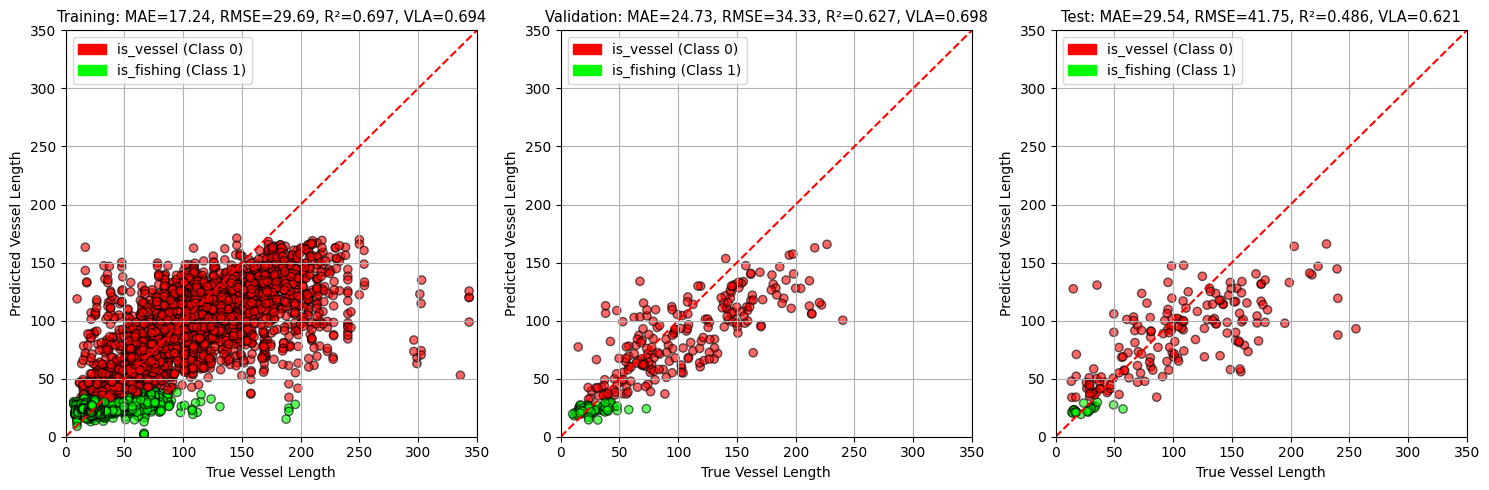

In [21]:
# Display predictded versus true vessel length plots for each split (use the rf regressor plot function)

# Create a temporary RF regressor instance just for plotting
temp_regressor = VesselLengthRegressor()

# Prepare plot data dictionary - extract 'overall' metrics
plot_data = {
    'train_true': y_train, 'train_pred': y_train_pred,
    'val_true': y_val, 'val_pred': y_val_pred,
    'test_true': y_test, 'test_pred': y_test_pred,
    'train_metrics': train_mlp_metrics['overall'],
    'val_metrics': val_mlp_metrics['overall'],
    'test_metrics': test_mlp_metrics['overall'],
    'train_classes': X_train[:, -1],
    'val_classes': X_val[:, -1],
    'test_classes': X_test[:, -1]
}

# Generate all three plots side by side
temp_regressor.plot_results(plot_data)

### 3.3 CNN regressor

#### 3.3.1 Data preparation

First generate predictions on training data and export and save image sub-crops based on the predicted bounding boxes. Analyse the sub-crops to determine an optimal size to re-size all the sub-crops, then resize them.

In [115]:
# Generate training prediction subcrops
run_inference_and_save_results(
     model_path=model_path,
     test_images_dir="/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal",
     output_dir="/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds",
     conf_threshold=0.25,
     iou_threshold=0.7
)

Found 8396 images to process


Processing images: 100%|███████████████████████████████████████████████████████████| 8396/8396 [44:35<00:00,  3.14img/s]


Inference completed!
Results saved to: /mnt/h/SARFish/Generated/SLC/test/crops_png_alt/images_hvrt_msc_bal_preds/detection_results.txt
Cropped images saved to: /mnt/h/SARFish/Generated/SLC/test/crops_png_alt/images_hvrt_msc_bal_preds/crops
Total images processed: 8396


In [119]:
# Analyse the subcrop dimensions
analyse_crops("/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops")

Analyzing crops in: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops
Directory exists: ✓
Found 7693 image files
First few files:
  - 0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_aug0_vflip_translate_proc_is_vessel_0_conf0.567.png
  - 0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_original_proc_is_vessel_0_conf0.443.png
  - 0d8ed29b0760dc59v_043.22273045000000024629_014.93491904999999952963_swath1_aug0_hflip_rotate_proc_is_vessel_0_conf0.287.png
  - 0d8ed29b0760dc59v_043.22273045000000024629_014.93491904999999952963_swath1_original_proc_is_vessel_0_conf0.577.png
  - 0d8ed29b0760dc59v_043.28511705999999747974_014.51577484000000062281_swath1_original_proc_is_vessel_0_conf0.684.png

Analyzing dimensions...
  0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_aug0_vflip_translate_proc_is_vessel_0_conf0.567.png: 50 x 14
  0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000

In [54]:
# Resize images to 64 x 64 pixels (minimal upscaling)
!python ../src/resize_crops.py --crops "/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops" \
                        --output "/mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds_rsz24/crops" \
                        --size 24 24 --preserve-aspect

Resizing crops from: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds/crops
Output directory: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds_rsz24/crops
Target size: 24 x 24
Interpolation: bilinear
Mode: Aspect ratio preserving with padding color (0, 0, 0)
Resizing 7693 images to 24x24 with aspect ratio preservation...
Using bilinear interpolation with padding color: (0, 0, 0)
Resizing with aspect preservation: 100%|███| 7693/7693 [21:35<00:00,  5.94img/s]
Resizing complete! Images saved to: /mnt/h/SARFish/Generated/SLC/train/crops_png_alt/images_hvrt_msc_bal_preds_rsz24/crops
